# A demonstration of OMpy


Before this notebook is run on a new system, make sure to compile the Cython files by doing (in the top repo directory):

```python setup.py build_ext --inplace```

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget
# %matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import ompy as om
import logging
import pickle
plt.style.use('Solarize_Light2')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


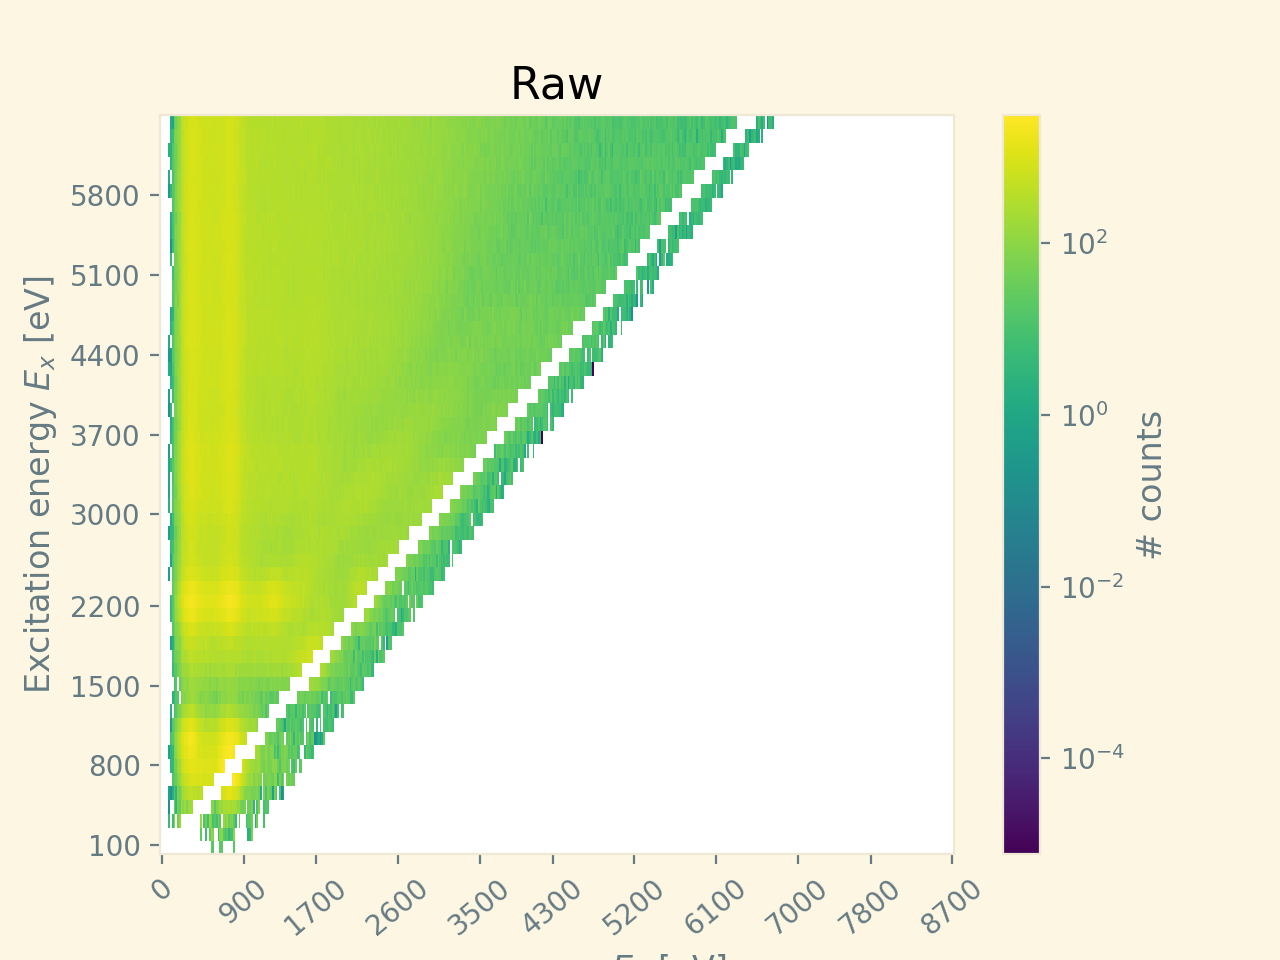

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f42c7710810>)

In [2]:
# Import raw matrix into instance of om.Matrix() and plot it
raw = om.example_raw('Dy164')
#raw.cut_diagonal()
raw.cut_diagonal((800, 0), (7500, 7300))
raw.cut('Ex', Emin=0.0, Emax=6500)

for Ex in raw.Ex:
    for Eg in raw.Eg:
        if abs(Ex - Eg) < 100:
            raw[raw.index_Ex(Ex), raw.index_Eg(Eg)] = 0
raw.plot()

<IPython.core.display.Javascript object>


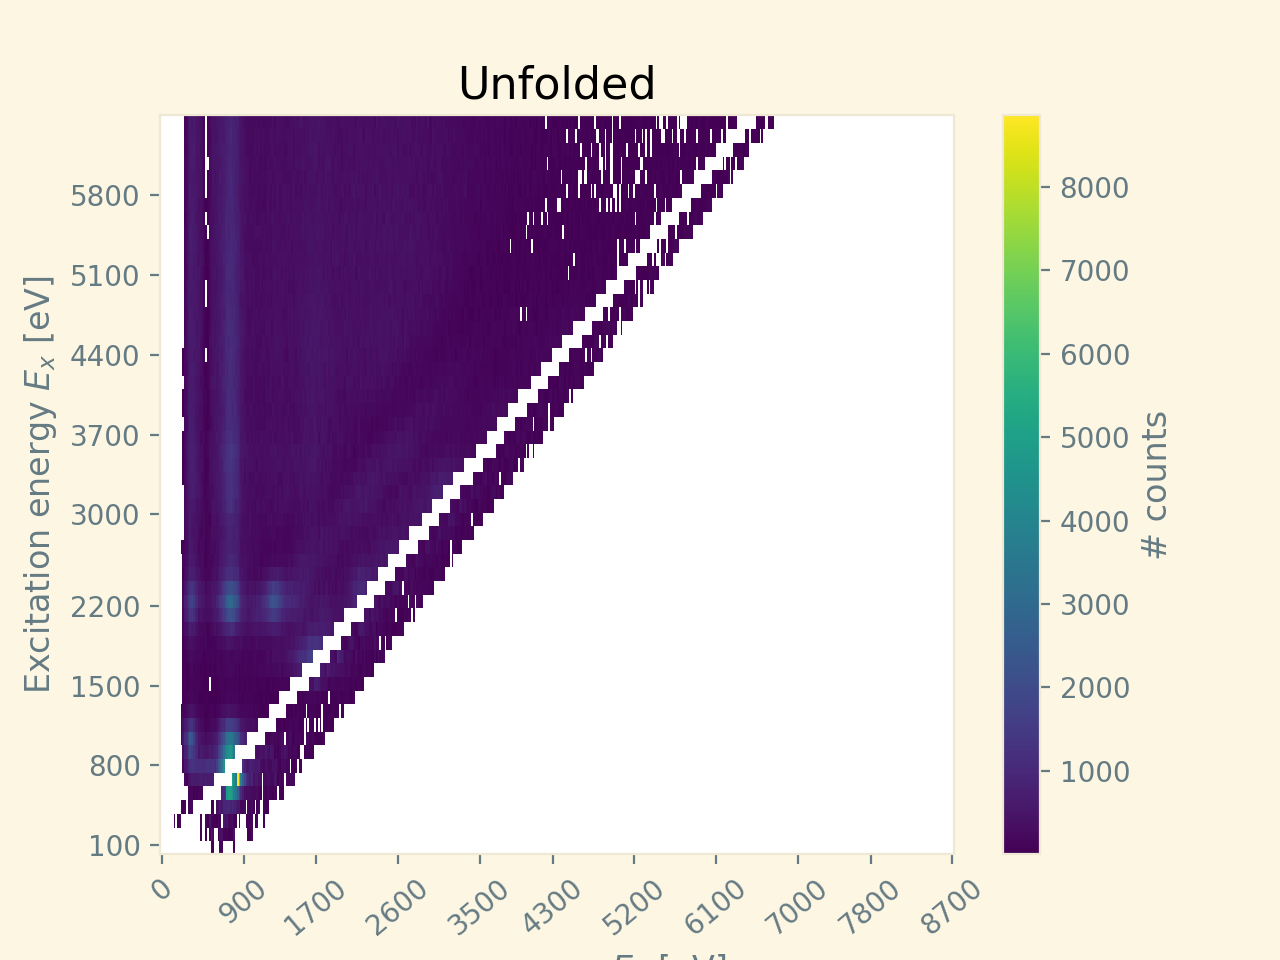

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f42c771e390>)

In [3]:
#logging.basicConfig(level=logging.INFO)
#logger = logging.getLogger("ompy.unfolder")
#logger.setLevel(logging.INFO)

response = om.Matrix(path="../../data/Dy164_response_matrix.m")
unfolder = om.Unfolder(response=response)
unfolded = unfolder.apply(raw)
unfolded.plot(scale='linear')

<IPython.core.display.Javascript object>


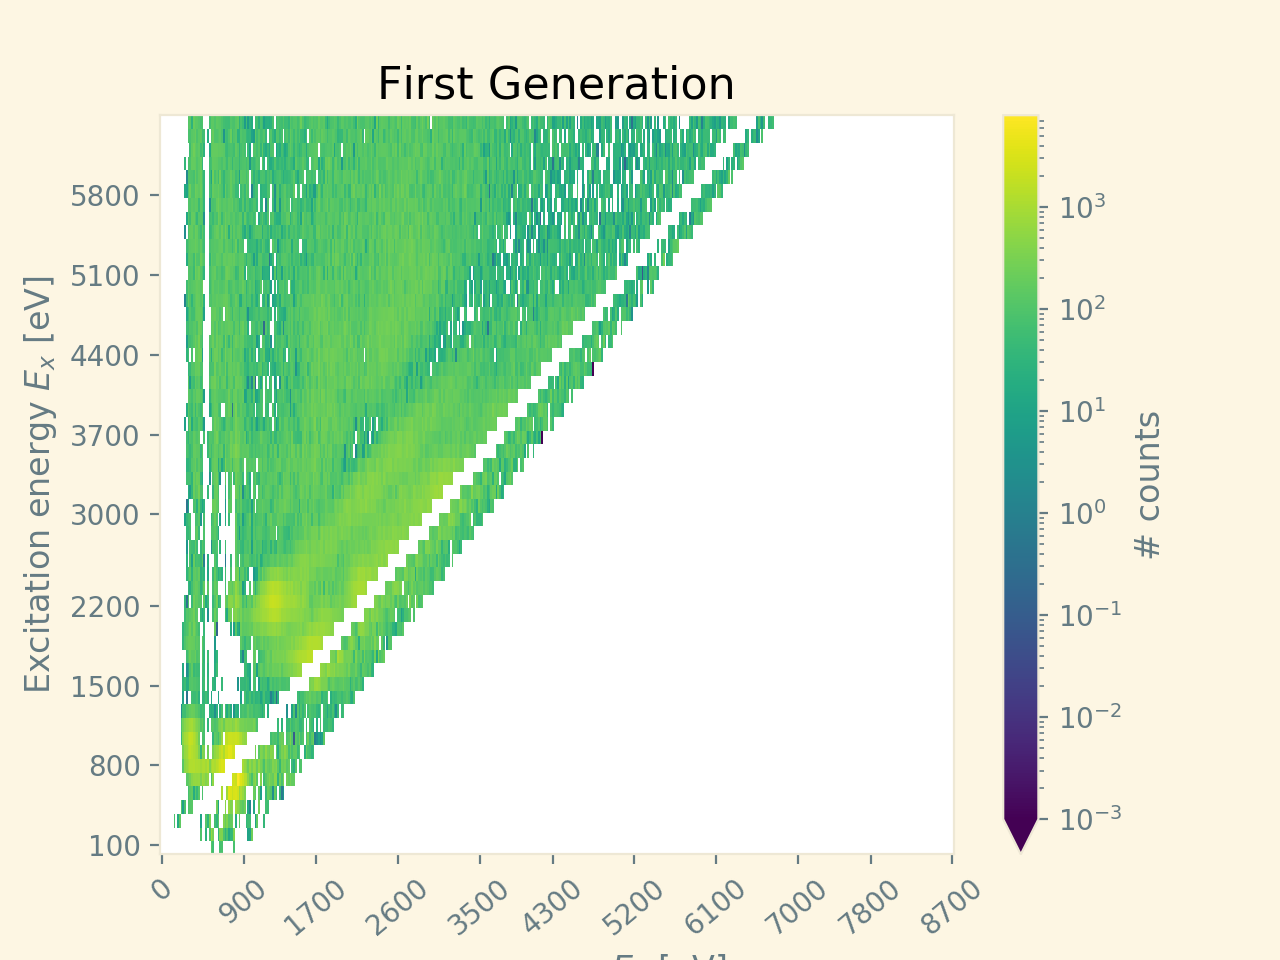

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f42be457350>)

In [4]:
firstgen = om.FirstGeneration()
firstgend = firstgen.apply(unfolded)
firstgend.plot(vmin=1e-3)

In [5]:
# Do error propagation in order to obtain an error matrix on the first generation spectrum
# Note that it requires an instance of MatrixAnalysis as input
#logger = logging.getLogger("ompy.ensemble")
#logger.setLevel(logging.INFO)

N_ensemble = 10

ensemble = om.Ensemble(raw=raw, path='chi²-ensemble')
ensemble.unfolder = unfolder
ensemble.first_generation_method = firstgen
ensemble.generate(number=N_ensemble)

100%|██████████| 10/10 [00:00<00:00, 206.55it/s]


<IPython.core.display.Javascript object>


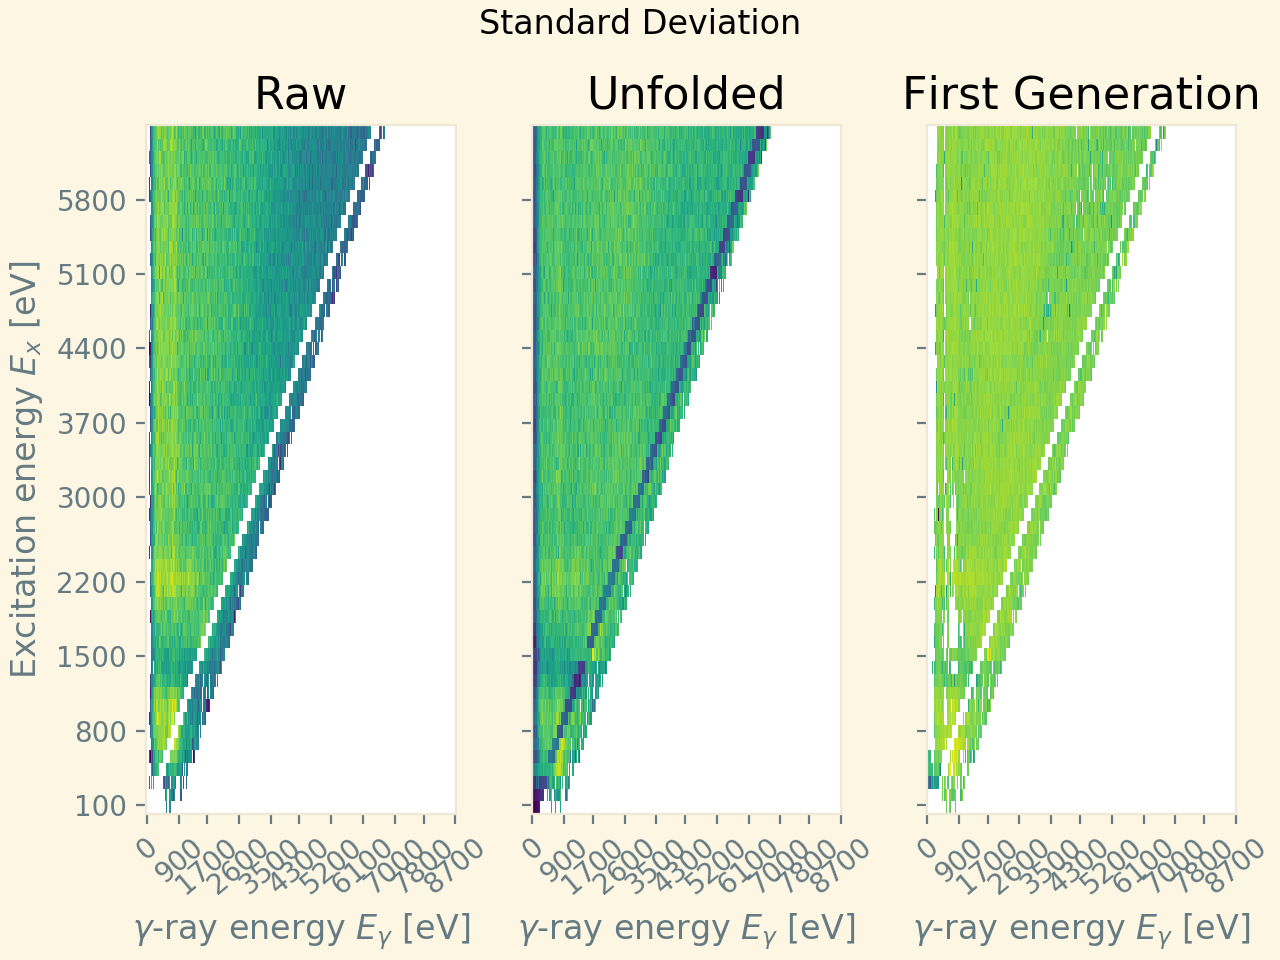

<IPython.core.display.Javascript object>


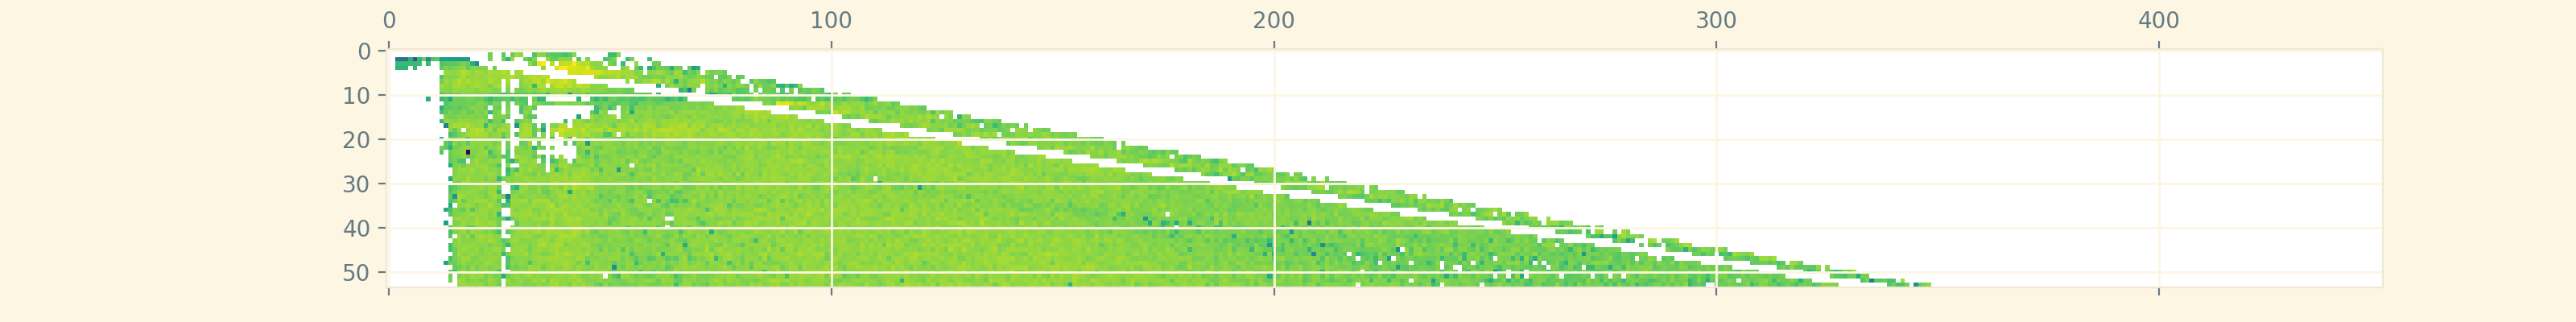

In [6]:
ensemble.plot()
from matplotlib.colors import LogNorm, Normalize, LinearSegmentedColormap


plt.matshow(ensemble.std_firstgen.values, norm=LogNorm())


## Extract nuclear level density and $\gamma$-strength function 

In [7]:
ensemble = om.Ensemble()
ensemble.load('ensemble')

In [8]:
bin_width_out = 120#150
Ex_min = 3000
Ex_max = 6500
Eg_min = 1000

ftol = 1e-3 # Fitting tolerance (in some unknown, relative units)
maxfev = None # maximum number of function evaluations

N_fits = 10#N_ensemble

<IPython.core.display.Javascript object>


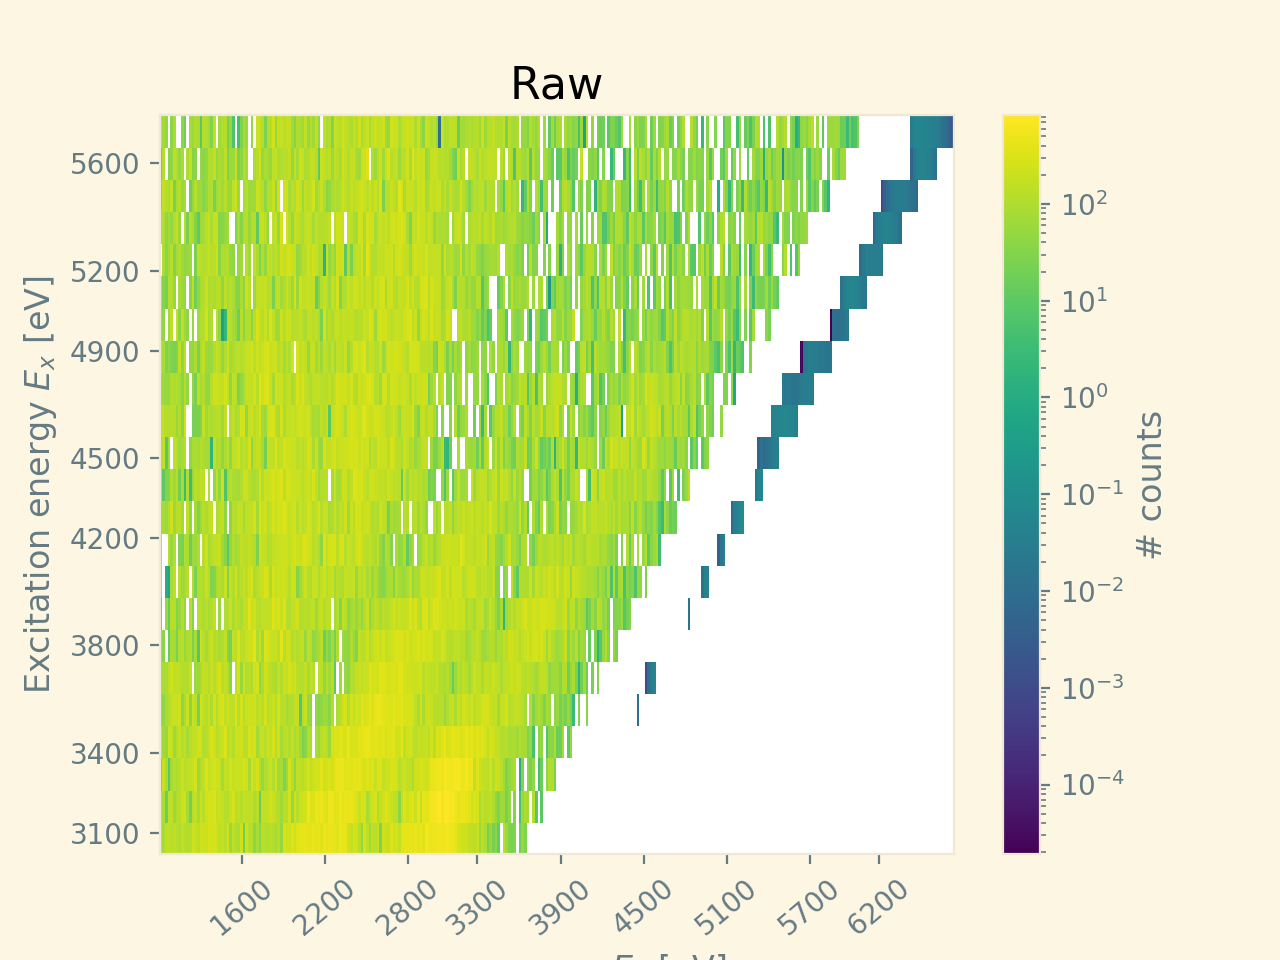

<IPython.core.display.Javascript object>


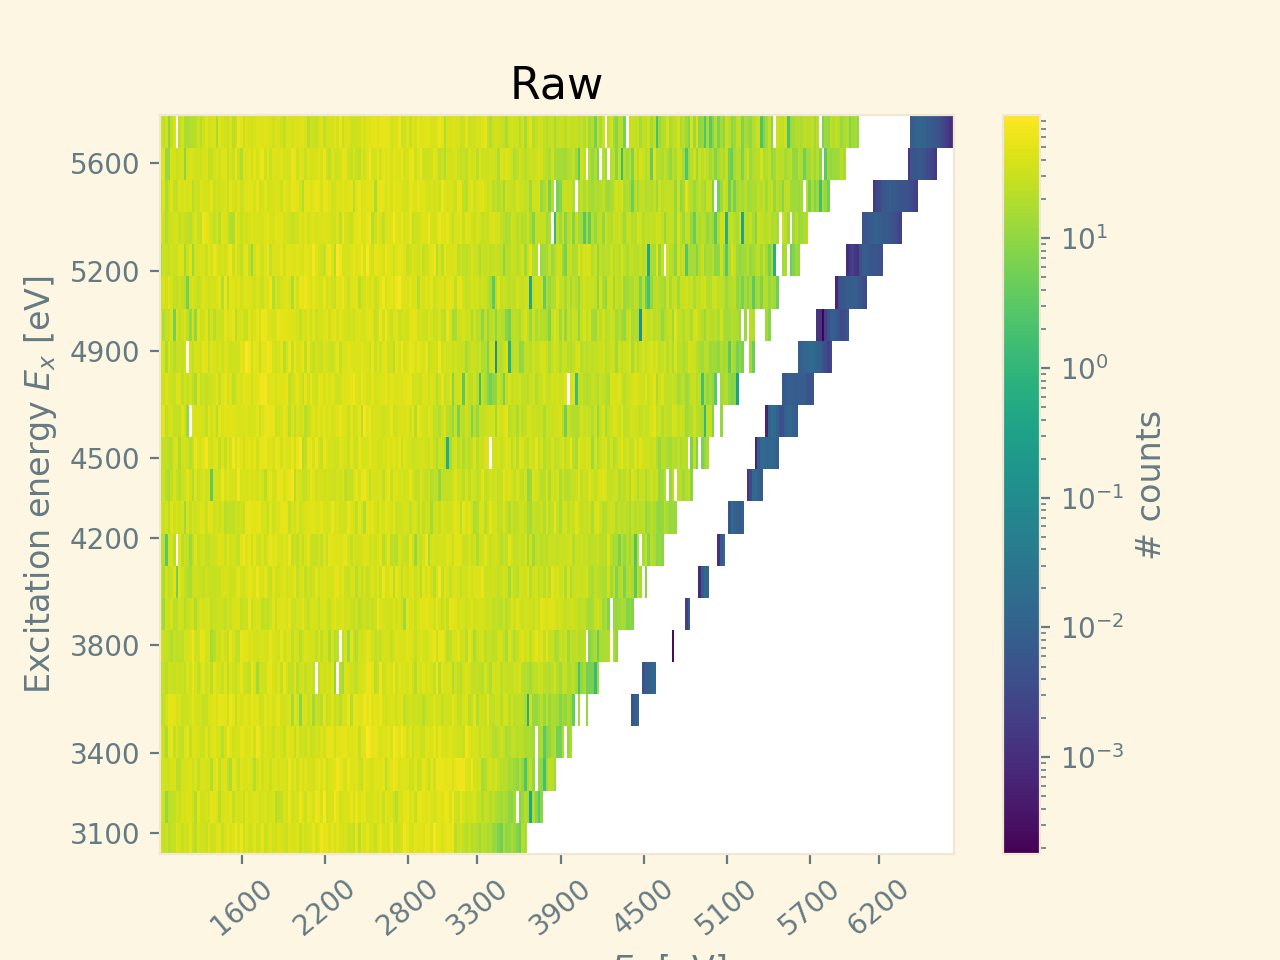

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f42c77dbf50>)

In [9]:
extractor = om.Extractor(ensemble)
cutout = ensemble.firstgen.trapezoid(3000, 5800, 1000, inplace=False)
cutout.plot()
std_cutout = ensemble.std_firstgen.cut_like(cutout, inplace=False)
std_cutout.plot()
#extractor.decompose(cutout)

In [10]:
ensemble = om.Ensemble()
ensemble.load('chi²-ensemble')
ex3 = om.Extractor(path='tst')
ex3.trapezoid = cutting_out
duck = ensemble.get_firstgen(0)
duck.values = duck.values.copy(order='C')
duck.Ex = duck.Ex.copy(order='C')
duck.Eg = duck.Eg.copy(order='C')
fish = ensemble.std_firstgen

fish.values = fish.values.copy(order='C')
fish.Ex = fish.Ex.copy(order='C')
fish.Eg = fish.Eg.copy(order='C')
cutting_out.act_on(duck)
cutting_out.act_on(fish)
nld, gsf, mat = ex3.decompose(duck, std=fish, product=True)

tst


NameError: name 'cutting_out' is not defined

In [ ]:
import copy
T = copy.deepcopy(gsf)
T.values = gsf.values*2*np.pi*mat.Eg**3
res = mat.diagonal_resolution()
#res = np.zeros_like(res)
mld = copy.deepcopy(nld)
mld.values[mld.values > 10]  =  0
mld.plot()
product = om.nld_T_product(mld.values, T.values, res, nld.E, mat.Eg, mat.Ex)
P = om.Matrix(product, Ex = mat.Ex, Eg=mat.Eg)
P.plot(scale='log', vmin=1e-9, vmax=1e0)
mat.plot(scale='log', vmin=1e-9, vmax=1e0)
print(om.chisquare(duck.values, P.values, fish.values))
om.chisquare(duck.values, mat.values, fish.values)

In [ ]:
f, dax  = duck.plot(); f, fax = fish.plot()
dax.set_xlim([3070, 3300])
fax.set_xlim([3070, 3300])
dax.set_ylim([3100, 3300])
fax.set_ylim([3100, 3300])
f, tax = mat.plot(scale='log', vmin=1e-9)
tax.set_xlim([3070, 3300])
tax.set_ylim([3100, 3300])
nld.plot()
gsf.plot()

In [13]:
extractor = om.Extractor()
extractor.path = 'chi²-extraction'
cutting_out = om.Action('matrix')
cutting_out.trapezoid(Ex_min=3100, Ex_max=5700, Eg_min=1000)
extractor.size = 10
extractor.trapezoid = cutting_out
extractor.extract_from(ensemble)

100%|██████████| 10/10 [00:00<00:00, 332.22it/s]


In [14]:
cutting_out = om.Action('matrix')
cutting_out.trapezoid(Ex_min=3100, Ex_max=5700, Eg_min=1000)
extractor.size = 10
extractor.trapezoid = cutting_out
extractor.extract_from(ensemble)

100%|██████████| 10/10 [00:00<00:00, 669.45it/s]


In [ ]:
plot = interactive(lambda a, alpha: gsf.transform(a, alpha, inplace=False).plot(scale='log'), 
         a=(0, 10, 0.5), alpha=(-0.01, 0.002, 0.0001)); 
output = plot.children[-1]
output.layout.height = '700px'
plot

In [ ]:
extractor2 = om.Extractor()
extractor2.path = 'chi²-extraction2'
cutting_out = om.Action('matrix')
cutting_out.trapezoid(Ex_min=3100, Ex_max=5700, Eg_min=1000)
extractor2.size = 10
extractor2.trapezoid = cutting_out
extractor2.extract_from(ensemble)

In [ ]:
extractor = om.Extractor(path='chi²-extraction')
extractor2 = om.Extractor(path='chi²-extraction2')
ax_nld, ax_gsf = extractor.plot()
ax_nld.set_ylim([1e-1, 1e1])
ax_gsf.set_ylim([1e-14, 1e-10])

#extractor2.plot((ax_nld, ax_gsf))

ax_nld, ax_gsf = extractor2.plot()
ax_nld.set_ylim([1e-1, 1e1])
ax_gsf.set_ylim([1e-14, 1e-10])

In [ ]:
extractor = om.Extractor(path='chi²-extraction')

extractor2 = om.Extractor(path='chi²-extraction2')
calib = extractor.gsf[0].calibration()
edges = om.E_array_from_calibration(calib['a0'], calib['a1']*3, E_max=extractor.gsf[0].E.max())
for i in range(extractor.size):
    gsf = extractor.gsf[i]
    gsf = om.rebin_1D(gsf.values, gsf.E, edges)
    extractor.gsf[i]= om.Vector(gsf, edges)
   
calib = extractor2.gsf[0].calibration()
edges = om.E_array_from_calibration(calib['a0'], calib['a1']*3, E_max=extractor2.gsf[0].E.max())
for i in range(extractor2.size):
    gsf = extractor2.gsf[i]
    gsf = om.rebin_1D(gsf.values, gsf.E, edges)
    extractor2.gsf[i]= om.Vector(gsf, edges)

In [ ]:
fig, (ax_nld, ax_gsf) = extractor.plot()
ax_nld.set_ylim([1e-1, 1e1])
ax_gsf.set_ylim([1e-14, 1e-10])

In [ ]:
extractor = om.Extractor(path='extraction_ensemble')
extractor.plot()

om.Action('Vector').\
    transform(const=1, alpha=1e-3, inplace=True).\
    map(extractor.nld)

extractor.plot()